**Участник 1: Конакбиев Хаким**

**Участник 2: Бокишев Данияр**

В данном проекте мы будем анализировать поездки на такси в Нью Йорке и попытаемся предсказать длительность поездки.

Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)

Скачать можно либо по ссылке выше, либо [тут](https://disk.yandex.ru/d/tLYfWH3ETqI5yA)

**Начнем!**

Загрузим все необходимые библиотеки и для красоты загрузим карту Москвы.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")

In [55]:
!pip install folium

In [56]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

In [57]:
df = pd.read_csv('train.csv')
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [58]:
from datetime import datetime

df = df.drop("dropoff_datetime", axis=1)
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

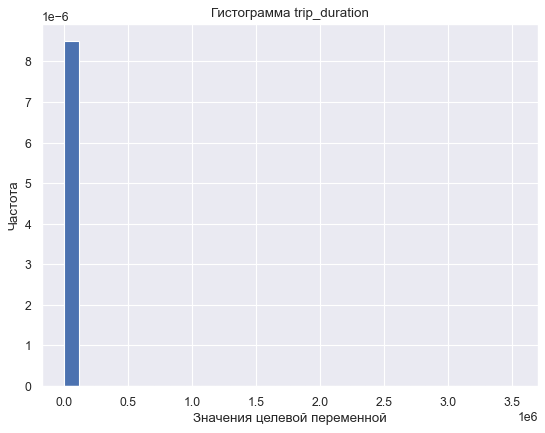

In [59]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(df["trip_duration"], density=True, bins=30)
plt.xlabel("Значения целевой переменной")
plt.ylabel("Частота")
plt.title("Гистограмма trip_duration")
plt.show()

Как видно из вышепредставленного графика выборочной функции плотности (гистограммы) целевой переменной trip_duration,
в выборке имеются значительные по величине выбросы, которые не дают адекватно оценить распределение элементов в выборке.

"Выбросами" данные значения являются только с точки зрения их величины, но не с точки зрения их важности!

Наблюдается большой разрыв между медианным и максимальным значением в выборке, что предполагает проведение некоторой обработки 
данных для удобной визуализации распределения основной массы значений целевой переменной:


In [60]:
print(f"""Медиана: {np.median(df["trip_duration"])}""")
print(f"""Максимум: {np.max(df["trip_duration"])}""")

Медиана: 662.0
Максимум: 3526282


Небольшое количество экспериментов дало понять, что основная масса данных находится по крайней мере в пределах от 0 до 5к:

In [61]:
print(f"""Кол-во данных меньше 5к: {sum(df["trip_duration"] < 5000)}""")
print(f"""Кол-во данных больше 5к: {sum(df["trip_duration"] > 5000)}""")

Кол-во данных меньше 5к: 1454870
Кол-во данных больше 5к: 3773


Поэтому построим гистограмму распределения trip_duration без учета выбросов:


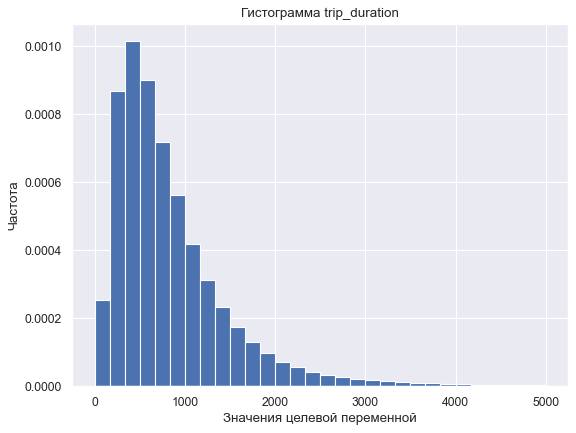

In [62]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(df[df["trip_duration"] < 5000]["trip_duration"], density=True, bins=30)
plt.xlabel("Значения целевой переменной")
plt.ylabel("Частота")
plt.title("Гистограмма trip_duration")
plt.show()

Распределение trip_duration напоминает экспоненциальное распределение, однако в отличие от последнего в начале наблюдается небольшой рост плотности.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: Основное отличие между RMSLE и RMSE - это операция взятия логарифма от целевой и предсказанной переменной, что значительно уменьшает величину реакции метрики на значительные выбросы. Другими словами, авторы выбрали RMSLE вместо RMSE для того, чтобы их модель обучалась в большей степени с учетом специфики основной массы данных и в меньшей степени учитывала выбросы.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: $$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} \to min$$<br>
$$\text{MSE}(X, \hat{y}_i, \hat{a}(x_i)) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2 \to min$$<br>
**При этом мы знаем, что:**<br>
$$\hat{y}_i = \log{(y_i + 1)}$$<br>
$$\hat{a}(x_i) = \log{(a(x_i) + 1)}$$<br>
**Получаем следующее:**<br>
$$\text{MSE}(X, \hat{y}_i, \hat{a}(x_i)) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \to min$$<br>
**C учетом того, что корень (монотонное положительное преобразование) не будет влиять на результат максимизации обоих выражений, оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$**


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [63]:
df["log_trip_duration"] = np.log1p(df["trip_duration"])
df = df.drop("trip_duration", axis=1)

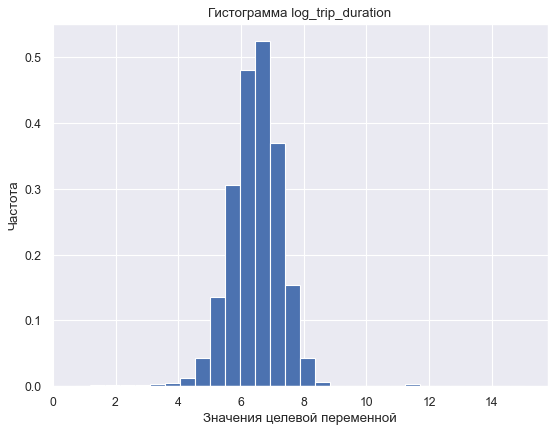

In [64]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(df["log_trip_duration"], density=True, bins=30)
plt.xlabel("Значения целевой переменной")
plt.ylabel("Частота")
plt.title("Гистограмма log_trip_duration")
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

Очевидно, что наилучшим константным предсказанием является среднее по выборке:

In [65]:
constant_prediction = np.mean(df["log_trip_duration"])
y = df["log_trip_duration"]
print(f"""MSE: {sum(np.square(y - constant_prediction))/len(y)}""")

MSE: 0.6332327625406583


## Часть 1. Изучаем `pickup_datetime` (2 балла)

Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

Добавим в датасет дополнительную переменную day_of_the_year, показывающую день года каждой начатой поездки:

In [66]:
df["day_of_the_year"] = df.apply(lambda row: row["pickup_datetime"].dayofyear, axis=1)

Так как дней в году достаточно много, то удобнее будет изобразить зависимость количества поездок от дня в году в форме линии, а не в виде столбцов.
Подготовим данные для визуализации:

In [67]:
day_of_the_year_count = df.groupby("day_of_the_year").size().reset_index(name="count")
day_of_the_year_count

,day_of_the_year,count
0,1,7162
1,2,6512
2,3,6353
3,4,6725
4,5,7204
...,...,...
177,178,7084
178,179,7311
179,180,7253
180,181,7623


<Figure size 1200x720 with 0 Axes>

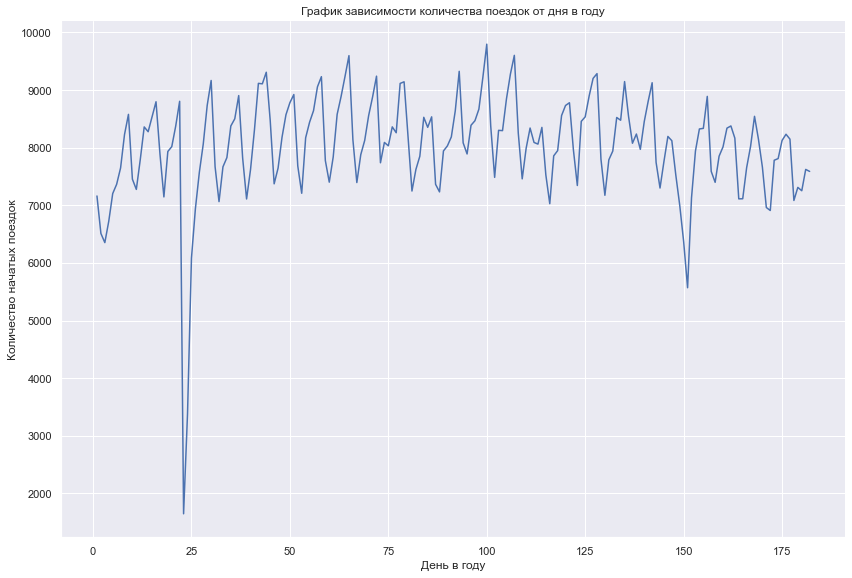

In [68]:
plt.figure(figsize=(15, 9), dpi=80)
sns.relplot(data=day_of_the_year_count, x="day_of_the_year", y="count", kind="line", height=8, aspect=1.5)
plt.xlabel("День в году")
plt.ylabel("Количество начатых поездок")
plt.title("График зависимости количества поездок от дня в году")
plt.show()                

Посмотрим в какие дни года произошли сильные просадки по количеству начатых поездок:

In [69]:
df.groupby("day_of_the_year").size().sort_values()

day_of_the_year
23     1648
24     3383
151    5570
25     6084
3      6353
       ... 
44     9309
93     9325
65     9597
107    9602
100    9796
Length: 182, dtype: int64

Как видно из вышепредставленных данных, 23-й (так же 24 и 25) и 151-й дни года оказались самыми неудачными с точки зрения количества поездок:

In [70]:
print(f"""First bad day: {df[df["day_of_the_year"] == 23]["pickup_datetime"].iloc[0].strftime('%Y-%m-%d')}""")
print(f"""Second bad day: {df[df["day_of_the_year"] == 151]["pickup_datetime"].iloc[0].strftime('%Y-%m-%d')}""")

First bad day: 2016-01-23
Second bad day: 2016-05-30


1-го января 2016-го года губернатор штата Нью-Йорк Эндрю Куомо запретил автомобильное движение в городе Нью-Йорк из-за снежной бури "Джонас", которая накрыла мегаполис в субботу. 30-го мая 2016-го произошла серия нападений в четырех районах Нью-Йорка.

Добавим в датасет дополнительные переменные `day_name` и `day_hour`, показывающие день недели и время в часах в течение дня каждой начатой поездки соответственно:

In [71]:
df["week_day"] = df.apply(lambda row: row["pickup_datetime"].day_name(), axis=1)
df["day_hour"] = df.apply(lambda row: row["pickup_datetime"].hour, axis=1)

Подготовим данные для визуализации:

In [72]:
trip_count = df.groupby("week_day").size()

trips_weekday = [trip_count["Monday"],
                 trip_count["Tuesday"],
                 trip_count["Wednesday"],
                 trip_count["Thursday"],
                 trip_count["Friday"],
                 trip_count["Saturday"],
                 trip_count["Sunday"]]

week_days = ["Monday",
             "Tuesday",
             "Wednesday",
             "Thursday",
             "Friday",
             "Saturday",
             "Sunday"]

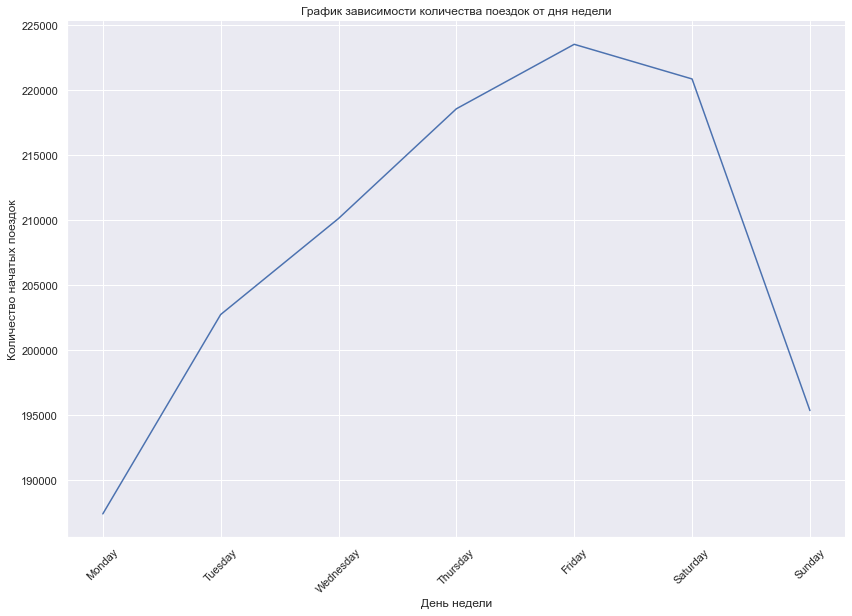

In [73]:
sns.relplot(x=week_days, y=trips_weekday, kind="line",
            height=8, aspect=1.5)
plt.xlabel("День недели")
plt.xticks(rotation=45)
plt.ylabel("Количество начатых поездок")
plt.title("График зависимости количества поездок от дня недели")
plt.show()

Подготовим данные для визуализации:

In [74]:
df_hour = df.groupby("day_hour").size().reset_index(name="count")
df_hour

,day_hour,count
0,0,53248
1,1,38571
2,2,27972
3,3,20895
4,4,15792
5,5,15002
6,6,33248
7,7,55600
8,8,67053
9,9,67663


<Figure size 1200x720 with 0 Axes>

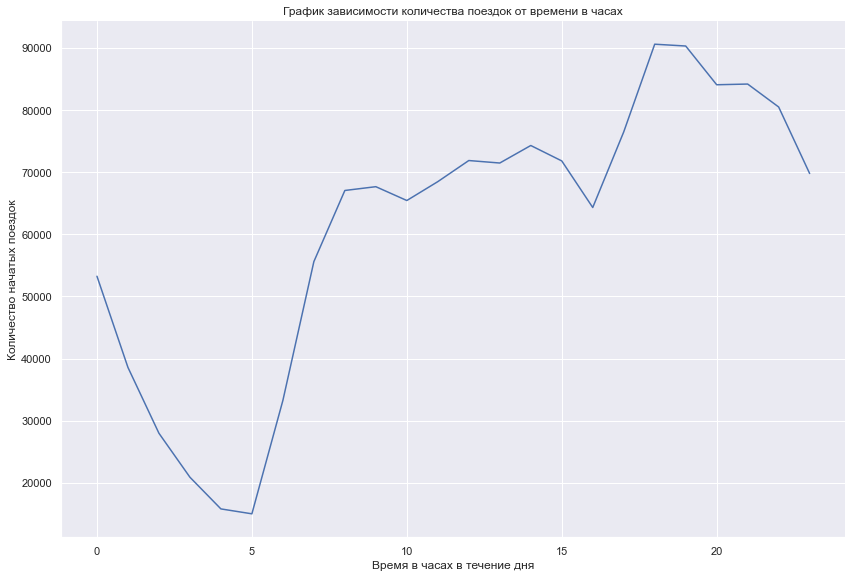

In [75]:
plt.figure(figsize=(15, 9), dpi=80)
sns.relplot(data=df_hour, x="day_hour", y="count", kind="line", height=8, aspect=1.5)
plt.xlabel("Время в часах в течение дня")
plt.ylabel("Количество начатых поездок")
plt.title("График зависимости количества поездок от времени в часах")
plt.show()

Нарисуем на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашиваем в разные цвета, воспользуемся `hue` в `sns.relplot`). 

Аналогично нарисуем зависимости количества поездок от часа в сутках для разных дней недели.

Добавим в датасет дополнительную переменную month_name, показывающую название месяца в году каждой начатой поездки:

In [76]:
df["month_name"] = df.apply(lambda row: row["pickup_datetime"].month_name(), axis=1)

Подготовим данные для визуализации:

In [77]:
df_hour_month = df.groupby(["day_hour", "month_name"]).size().reset_index(name="count")
df_hour_month

,day_hour,month_name,count
0,0,April,9185
1,0,February,8445
2,0,January,8330
3,0,June,9150
4,0,March,8992
...,...,...,...
139,23,February,11042
140,23,January,10241
141,23,June,11899
142,23,March,12172


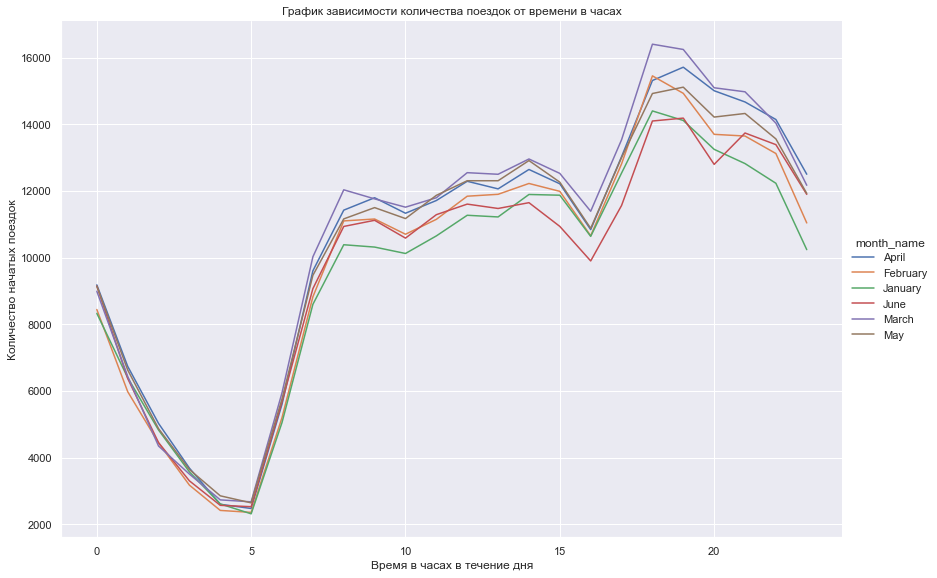

In [78]:
sns.relplot(data=df_hour_month, x="day_hour", y="count", kind="line", hue="month_name",
            height=8, aspect=1.5)
plt.xlabel("Время в часах в течение дня")
plt.ylabel("Количество начатых поездок")
plt.title("График зависимости количества поездок от времени в часах")
plt.show()

Мы начали анализировать данные о времени начала поездки. 

В дальнейшем мы планируем проанализировать отдельно координаты начала и конца поездки. 

После первичного анализа и визуализации мы разделим выборку на обучающую и тестовую и построим линейную регрессию на каждый пункт.

Затем проанализируем все оставшиеся параметры в целом.

**На этом пока все, остальное доделаем позже :)**

Пока вот вам порция мемов:
Это ссылки на рилсы 
1. [Политический](https://www.instagram.com/reel/CsJRN_pLNhF/?igshid=MTIyMzRjYmRlZg==)
2. [Видео подруг с Эконома](https://www.instagram.com/reel/CsRIs1yLTfA/?igshid=NTc4MTIwNjQ2YQ==)
3. [И просто смешной](https://www.instagram.com/reel/Cq7am8jgCNZ/?igshid=MTIyMzRjYmRlZg==)